In [4]:
import pickle

BUNDLE_PATH = "_snapshots/olist_clean_bundle.pkl"  # 경로만 맞추면 됩니다.

with open(BUNDLE_PATH, "rb") as f:
    bundle = pickle.load(f)

# 변수로 바로 풀어서 사용
orders_clean       = bundle["orders_clean"]
order_items_clean  = bundle["order_items_clean"]
payments_clean     = bundle["payments_clean"]
reviews_clean      = bundle["reviews_clean"]
customers_clean    = bundle["customers_clean"]
geolocation_clean  = bundle["geolocation_clean"]
products_clean     = bundle["products_clean"]
sellers_clean      = bundle["sellers_clean"]
category_tr_clean  = bundle["category_tr_clean"]

print("✅ Restored all *_clean DataFrames")

✅ Restored all *_clean DataFrames


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

In [14]:
products_clean.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_en
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [13]:
# =========================================================
# 카테고리별 구매주기 & 제품 라이프사이클 분석 (컬러 시각화 포함)
# 전제: *_clean DataFrame들이 이미 메모리에 로드되어 있음
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) 가드 & 카테고리명 보장 ----------
need = {"orders_clean","order_items_clean","products_clean"}
missing = [x for x in need if x not in globals()]
if missing:
    raise NameError(f"필요 DF 없음: {missing}")

# 카테고리 영문명 생성(없으면 번역 테이블 사용)
if "category_en" not in products_clean.columns:
    products_clean = products_clean.copy()
    if "category_tr_clean" in globals() and "product_category_name" in products_clean.columns:
        _map = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
        products_clean["category_en"] = products_clean["product_category_name"].map(_map).fillna("unknown")
    else:
        products_clean["category_en"] = products_clean.get("product_category_name", "unknown")

# ---------- 1) 베이스 결합 ----------
base = (orders_clean[["order_id","customer_id","order_purchase_timestamp","order_status"]]
        .merge(order_items_clean[["order_id","product_id","price"]], on="order_id", how="inner")
        .merge(products_clean[["product_id","category_en"]], on="product_id", how="left"))

# 분석에 포함할 주문상태(너무 보수적으로 'delivered'만 쓰면 표본이 줄 수 있음)
valid_status = ["delivered","invoiced","shipped","processing","created"]
base = base[base["order_status"].isin(valid_status)].copy()

# 날짜 컬럼 정규화
base["order_date"]  = pd.to_datetime(base["order_purchase_timestamp"], errors="coerce").dt.normalize()
base["order_month"] = base["order_date"].values.astype("datetime64[M]")
base["category_en"] = base["category_en"].fillna("unknown")

# ---------- 2) 구매주기(Inter-purchase) ----------
# 고객×카테고리×주문일 단위(중복 날짜 제거) → 날짜 차이(diff)
cust_cat_day = (base.groupby(["customer_id","category_en","order_date"])["order_id"]
                    .nunique().reset_index()
                    .sort_values(["customer_id","category_en","order_date"]))

ip_rows, firstgap_rows = [], []
for (cust, cat), g in cust_cat_day.groupby(["customer_id","category_en"], sort=False):
    d = g["order_date"].drop_duplicates().sort_values().values
    if len(d) >= 2:
        gaps = (pd.Series(d).diff().dropna().dt.days.values)
        # 전체 간격 저장
        ip_rows.extend({"customer_id":cust, "category_en":cat, "gap_days": int(gd)} for gd in gaps)
        # 첫 재구매 간격만 별도 저장
        firstgap_rows.append({"customer_id":cust, "category_en":cat, "first_gap_days": int(gaps[0])})

ip_df = pd.DataFrame(ip_rows)
firstgap_df = pd.DataFrame(firstgap_rows)

buyers_per_cat = (cust_cat_day.groupby("category_en")["customer_id"]
                  .nunique().reset_index().rename(columns={"customer_id":"buyers"}))

def _pct(s, q): 
    return float(np.percentile(s, q)) if len(s)>0 else np.nan

# 카테고리별 요약(중앙값/분위수/평균/95%/재구매율/반복구매자 비중)
if len(ip_df)>0:
    cycle_stats = (ip_df.groupby("category_en")["gap_days"]
                      .agg(n_gaps="count",
                           median_days="median",
                           p25=lambda s:_pct(s,25),
                           p75=lambda s:_pct(s,75),
                           mean_days="mean",
                           p95=lambda s:_pct(s,95))
                      .reset_index())
else:
    cycle_stats = pd.DataFrame(columns=["category_en","n_gaps","median_days","p25","p75","mean_days","p95"])

if len(firstgap_df)>0:
    first_stats = (firstgap_df.groupby("category_en")["first_gap_days"].agg(
                    customers_with_repeat="count",
                    rep_30=lambda s: float((s<=30).mean()),
                    rep_60=lambda s: float((s<=60).mean()),
                    rep_90=lambda s: float((s<=90).mean())
                   ).reset_index())
else:
    first_stats = pd.DataFrame(columns=["category_en","customers_with_repeat","rep_30","rep_60","rep_90"])

category_cycle_summary = (cycle_stats
                          .merge(first_stats, on="category_en", how="left")
                          .merge(buyers_per_cat, on="category_en", how="left"))

category_cycle_summary["repeat_share"] = (category_cycle_summary["customers_with_repeat"] /
                                          category_cycle_summary["buyers"]).fillna(0.0)

category_cycle_summary = category_cycle_summary.sort_values(
    ["median_days","p75"], na_position="last"
).reset_index(drop=True)

print("=== 카테고리별 구매주기 요약 (상위 15) ===")
display(category_cycle_summary.head(15))

# 재구매 누적곡선(CDF) 데이터(구매자 많은 6개)
top6_by_buyers = buyers_per_cat.sort_values("buyers", ascending=False).head(6)["category_en"].tolist()
rows = []
for cat in top6_by_buyers:
    s = firstgap_df.loc[firstgap_df["category_en"]==cat, "first_gap_days"].dropna()
    if len(s)==0: 
        continue
    for d in range(7, 181, 7):  # 7일 간격, 최대 180일
        rows.append({"category_en":cat, "day": d, "cum_ratio": float((s<=d).mean())})
category_reorder_curve = pd.DataFrame(rows)

# ---------- 3) 제품 라이프사이클 ----------
# 제품×월 매출 + 3개월 이동평균
prod_m = (base.groupby(["product_id","category_en","order_month"])["price"]
             .sum().reset_index().rename(columns={"price":"sales"}))
prod_m = prod_m.sort_values(["product_id","order_month"])
prod_m["ma3"] = prod_m.groupby("product_id")["sales"].transform(lambda s: s.rolling(3, min_periods=1).mean())

# 제품별 요약(최초/최종/피크/나이/피크까지 시간)
peak_idx = prod_m.groupby("product_id")["sales"].idxmax()
peak_map = prod_m.loc[peak_idx, ["product_id","order_month"]].rename(columns={"order_month":"peak_month"})
agg = (prod_m.groupby("product_id")
       .agg(category_en=("category_en","first"),
            first_month=("order_month","min"),
            last_month=("order_month","max"),
            months_active=("order_month","nunique"),
            total_sales=("sales","sum"))
       .reset_index()
       .merge(peak_map, on="product_id", how="left"))

agg["age_months"]   = ((agg["last_month"] - agg["first_month"]) / np.timedelta64(1,"M")).astype(float)
agg["time_to_peak"] = ((agg["peak_month"] - agg["first_month"]) / np.timedelta64(1,"M")).astype(float)

# 간단 단계 판정(최근 3개월 MA vs 직전 3개월 MA)
def _stage_of_product(g, recent=3, prev=3):
    g = g.sort_values("order_month")
    if len(g) < (recent+prev):
        return "introduction"
    last = g["ma3"].tail(recent).mean()
    prevm= g["ma3"].tail(recent+prev).head(prev).mean()
    if prevm<=0:
        return "introduction"
    delta = (last - prevm) / prevm
    if len(g) <= 3:
        return "introduction"
    if delta >= 0.15:
        return "growth"
    if delta <= -0.15 and len(g) >= 6:
        return "decline"
    if abs(delta) < 0.10:
        return "mature"
    return "mature"

stage_map = {}
for pid, g in prod_m.groupby("product_id", sort=False):
    stage_map[pid] = _stage_of_product(g)

product_lifecycle = agg.copy()
product_lifecycle["stage"] = product_lifecycle["product_id"].map(stage_map)

# 카테고리별 단계 구성(비중)
cnt = (product_lifecycle.groupby(["category_en","stage"])["product_id"].nunique()
       .reset_index().pivot(index="category_en", columns="stage", values="product_id").fillna(0))
cnt["total_products"] = cnt.sum(axis=1)
lifecycle_by_category = cnt.div(cnt["total_products"], axis=0).fillna(0.0)

print("=== 제품 라이프사이클 (상위 10행) ===")
display(product_lifecycle.head(10))

# ---------- 4) 시각화 ----------
# 팔레트(선명한 컬러)
colors = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
          "#EDC948","#B07AA1","#FF9DA7","#9C755F","#2E7C9E","#86BCB6","#FABFD2"]

# (A) 구매주기 박스플롯 — 상위 8개(구매자 기준)
top8 = buyers_per_cat.sort_values("buyers", ascending=False).head(8)["category_en"].tolist()
if len(ip_df)>0 and len(top8)>0:
    plt.figure(figsize=(12,5))
    data = [ip_df.loc[ip_df["category_en"]==c, "gap_days"].values for c in top8]
    bp = plt.boxplot(data, labels=top8, showfliers=False)
    for i, line in enumerate(bp['boxes']):
        line.set_color(colors[i % len(colors)])
    plt.title("카테고리별 구매주기 분포(일) — 상위 8개")
    plt.xlabel("Category"); plt.ylabel("Gap (days)")
    plt.xticks(rotation=20)
    plt.tight_layout(); plt.show()

# (B) 재구매 누적곡선(CDF) — 상위 6개
if not category_reorder_curve.empty:
    plt.figure(figsize=(12,5))
    for i, (cat, g) in enumerate(category_reorder_curve.groupby("category_en", sort=False), 1):
        plt.plot(g["day"], g["cum_ratio"], label=cat, linewidth=2, color=colors[(i-1)%len(colors)])
    plt.title("재구매 누적 비율(첫 구매 → 두번째 구매까지)")
    plt.xlabel("Days since 1st purchase"); plt.ylabel("Cumulative ratio")
    plt.legend(frameon=False, ncol=3)
    plt.tight_layout(); plt.show()

# (C) 제품 ‘최고 판매 도달’ 시간 분포 (히스토그램)
valid_peak = product_lifecycle["time_to_peak"].replace([np.inf,-np.inf], np.nan).dropna()
if len(valid_peak)>0:
    plt.figure(figsize=(10,4))
    bins = np.arange(0, valid_peak.max()+3, 3)
    plt.hist(valid_peak, bins=bins, edgecolor="black", color=colors[0])
    plt.title("제품 출시→최고 판매까지 걸린 시간(개월) 분포")
    plt.xlabel("Months to Peak"); plt.ylabel("Product count")
    plt.tight_layout(); plt.show()

# (D) 카테고리별 단계 구성 — 상위 8개 스택 바
stages = [c for c in ["introduction","growth","mature","decline"] if c in lifecycle_by_category.columns]
if len(stages)>0:
    stack_base = lifecycle_by_category.loc[
        buyers_per_cat.sort_values("buyers", ascending=False).head(8)["category_en"],
        stages
    ].fillna(0.0)
    x = np.arange(len(stack_base))
    bottom = np.zeros(len(stack_base))
    plt.figure(figsize=(12,5))
    for i, s in enumerate(stages):
        vals = stack_base[s].values
        plt.bar(x, vals, bottom=bottom, label=s, color=colors[i % len(colors)])
        bottom += vals
    plt.title("카테고리별 제품 라이프사이클 구성(비중) — 상위 8개")
    plt.xticks(x, stack_base.index, rotation=20)
    plt.ylabel("Share")
    plt.legend(frameon=False, ncol=len(stages))
    plt.tight_layout(); plt.show()

print("✅ 완료: category_cycle_summary / category_reorder_curve / product_lifecycle / lifecycle_by_category 생성 및 시각화")


=== 카테고리별 구매주기 요약 (상위 15) ===


,category_en,n_gaps,median_days,p25,p75,mean_days,p95,customers_with_repeat,rep_30,rep_60,rep_90,buyers,repeat_share


KeyError: 'category_en'

=== 카테고리별 구매주기 요약 (상위 15) ===


,category_en,n_gaps,median_days,p25,p75,mean_days,p95,customers_with_repeat,rep_30,rep_60,rep_90,buyers,repeat_share


⚠️ 재구매(first_gap_days) 관측 카테고리가 없어 CDF 생성을 건너뜁니다.
=== 제품 라이프사이클 (상위 10행) ===


,product_id,category_en,first_month,last_month,months_active,total_sales,peak_month,age_months,time_to_peak,stage
0,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2018-05-01,2018-05-01,1,101.65,2018-05-01,0.0,0.0,introduction
1,00088930e925c41fd95ebfe695fd2655,auto,2017-12-01,2017-12-01,1,129.90,2017-12-01,0.0,0.0,introduction
2,0009406fd7479715e4bef61dd91f2462,bed_bath_table,2017-12-01,2017-12-01,1,229.00,2017-12-01,0.0,0.0,introduction
3,000b8f95fcb9e0096488278317764d19,housewares,2018-08-01,2018-08-01,1,117.80,2018-08-01,0.0,0.0,introduction
4,000d9be29b5207b54e86aa1b1ac54872,watches_gifts,2018-04-01,2018-04-01,1,199.00,2018-04-01,0.0,0.0,introduction
5,0011c512eb256aa0dbbb544d8dffcf6e,auto,2017-12-01,2017-12-01,1,52.00,2017-12-01,0.0,0.0,introduction
6,00126f27c813603687e6ce486d909d01,cool_stuff,2017-09-01,2017-09-01,1,498.00,2017-09-01,0.0,0.0,introduction
7,001795ec6f1b187d37335e1c4704762e,consoles_games,2017-10-01,2017-12-01,3,350.10,2017-12-01,2.0,2.0,introduction
8,001b237c0e9bb435f2e54071129237e9,bed_bath_table,2018-08-01,2018-08-01,1,78.90,2018-08-01,0.0,0.0,introduction
9,001b72dfd63e9833e8c02742adf472e3,furniture_decor,2017-02-01,2017-12-01,7,489.86,2017-02-01,10.0,0.0,mature


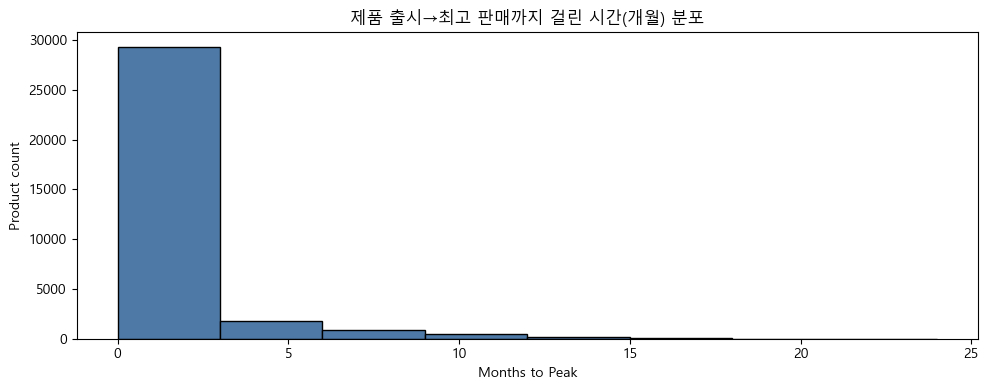

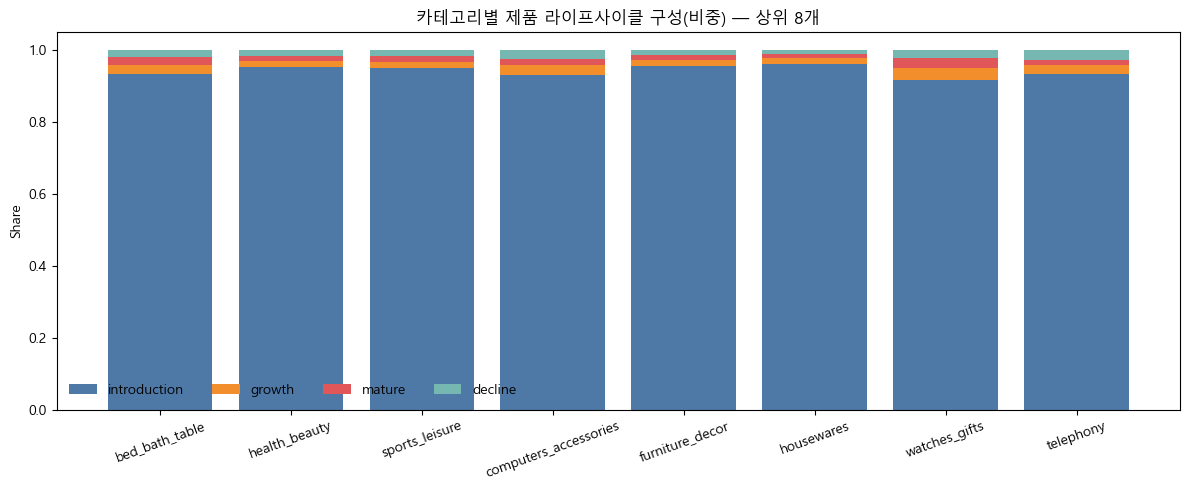

✅ 완료: category_cycle_summary / category_reorder_curve / product_lifecycle / lifecycle_by_category 생성 및 시각화


In [16]:
# =========================================================
# 카테고리별 구매주기 & 제품 라이프사이클 분석 (안전한 firstgap 처리 포함)
# 전제: 위에서 *_clean DF 로드/환경세팅 완료
# 산출물:
#   - category_cycle_summary, category_reorder_curve
#   - product_lifecycle, lifecycle_by_category
#   - 시각화 4종(박스플롯, CDF, 히스토그램, 스택바)
# =========================================================

# ---------- 0) 가드 & 카테고리명 보장 ----------
_need = {"orders_clean","order_items_clean","products_clean"}
_missing = [x for x in _need if x not in globals()]
if _missing:
    raise NameError(f"필요 DF 없음: {_missing}")

# products_clean에 category_en이 없으면 번역 테이블 사용
if "category_en" not in products_clean.columns:
    products_clean = products_clean.copy()
    if "category_tr_clean" in globals() and "product_category_name" in products_clean.columns:
        _map = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
        products_clean["category_en"] = products_clean["product_category_name"].map(_map).fillna("unknown")
    else:
        products_clean["category_en"] = products_clean.get("product_category_name", "unknown")

# ---------- 1) 베이스 결합 ----------
valid_status = ["delivered","invoiced","shipped","processing","created"]
base = (orders_clean[["order_id","customer_id","order_purchase_timestamp","order_status"]]
        .merge(order_items_clean[["order_id","product_id","price"]], on="order_id", how="inner")
        .merge(products_clean[["product_id","category_en"]], on="product_id", how="left"))
base = base[base["order_status"].isin(valid_status)].copy()
base["order_date"]  = pd.to_datetime(base["order_purchase_timestamp"], errors="coerce").dt.normalize()
base["order_month"] = base["order_date"].dt.to_period("M").dt.to_timestamp()
base["category_en"] = base["category_en"].fillna("unknown")

# ---------- 2) 구매주기(Inter-purchase) ----------
cust_cat_day = (base.groupby(["customer_id","category_en","order_date"])["order_id"]
                    .nunique().reset_index()
                    .sort_values(["customer_id","category_en","order_date"]))

ip_rows, firstgap_rows = [], []
for (cust, cat), g in cust_cat_day.groupby(["customer_id","category_en"], sort=False):
    d = g["order_date"].drop_duplicates().sort_values().values
    if len(d) >= 2:
        gaps = (pd.Series(d).diff().dropna().dt.days.values)
        # 전체 간격
        ip_rows.extend({"customer_id":cust, "category_en":cat, "gap_days": int(gd)} for gd in gaps)
        # 첫 재구매 간격
        firstgap_rows.append({"customer_id":cust, "category_en":cat, "first_gap_days": int(gaps[0])})

ip_df = pd.DataFrame(ip_rows)
firstgap_df = pd.DataFrame(firstgap_rows)

# --- 안전 패치: 비어 있어도 컬럼 보장 + dtype 정리 ---
for col in ["customer_id","category_en","first_gap_days"]:
    if col not in firstgap_df.columns:
        firstgap_df[col] = pd.Series(dtype="object")
firstgap_df["first_gap_days"] = pd.to_numeric(firstgap_df["first_gap_days"], errors="coerce")
firstgap_df["category_en"] = firstgap_df["category_en"].astype("string")

buyers_per_cat = (cust_cat_day.groupby("category_en")["customer_id"]
                  .nunique().reset_index().rename(columns={"customer_id":"buyers"}))

def _pct(s, q): 
    return float(np.percentile(s, q)) if len(s)>0 else np.nan

# 카테고리별 요약(중앙값/분위수/평균/95%/재구매율/반복구매자 비중)
if len(ip_df)>0:
    cycle_stats = (ip_df.groupby("category_en")["gap_days"]
                      .agg(n_gaps="count",
                           median_days="median",
                           p25=lambda s:_pct(s,25),
                           p75=lambda s:_pct(s,75),
                           mean_days="mean",
                           p95=lambda s:_pct(s,95))
                      .reset_index())
else:
    cycle_stats = pd.DataFrame(columns=["category_en","n_gaps","median_days","p25","p75","mean_days","p95"])

if len(firstgap_df)>0:
    first_stats = (firstgap_df.groupby("category_en")["first_gap_days"].agg(
                    customers_with_repeat="count",
                    rep_30=lambda s: float((s<=30).mean()),
                    rep_60=lambda s: float((s<=60).mean()),
                    rep_90=lambda s: float((s<=90).mean())
                   ).reset_index())
else:
    first_stats = pd.DataFrame(columns=["category_en","customers_with_repeat","rep_30","rep_60","rep_90"])

category_cycle_summary = (cycle_stats
                          .merge(first_stats, on="category_en", how="left")
                          .merge(buyers_per_cat, on="category_en", how="left"))

category_cycle_summary["repeat_share"] = (category_cycle_summary["customers_with_repeat"] /
                                          category_cycle_summary["buyers"]).fillna(0.0)

category_cycle_summary = category_cycle_summary.sort_values(
    ["median_days","p75"], na_position="last"
).reset_index(drop=True)

print("=== 카테고리별 구매주기 요약 (상위 15) ===")
display(category_cycle_summary.head(15))

# ---------- 3) 재구매 누적곡선(CDF) — 안전 생성 ----------
# 3-1) 실제 첫 재구매가 관측된 카테고리
_valid_cats = firstgap_df.loc[firstgap_df["first_gap_days"].notna(), "category_en"].dropna().unique().tolist()

# 3-2) 기본 후보: 구매자 많은 Top6 ∩ _valid_cats
_top6 = buyers_per_cat.sort_values("buyers", ascending=False).head(6)["category_en"].tolist()
_cats_for_curve = [c for c in _top6 if c in _valid_cats]

# 3-3) 대안: 재구매 데이터가 많은 카테고리 Top6
if len(_cats_for_curve) == 0 and len(_valid_cats) > 0:
    _rich = (firstgap_df.dropna(subset=["first_gap_days"])
                       .groupby("category_en")["customer_id"].nunique()
                       .sort_values(ascending=False).head(6).index.tolist())
    _cats_for_curve = _rich

# 3-4) 곡선 생성
category_reorder_curve = pd.DataFrame(columns=["category_en","day","cum_ratio"])
if len(_cats_for_curve) > 0:
    _rows = []
    for cat in _cats_for_curve:
        s = firstgap_df.loc[firstgap_df["category_en"]==cat, "first_gap_days"].dropna().astype(float)
        for d in range(7, 181, 7):  # 7일 간격, 최대 180일
            _rows.append({"category_en":cat, "day": d, "cum_ratio": float((s<=d).mean()) if len(s) else np.nan})
    category_reorder_curve = pd.DataFrame(_rows)
else:
    print("⚠️ 재구매(first_gap_days) 관측 카테고리가 없어 CDF 생성을 건너뜁니다.")

# ---------- 4) 제품 라이프사이클 ----------
prod_m = (base.groupby(["product_id","category_en","order_month"])["price"]
             .sum().reset_index().rename(columns={"price":"sales"}))
prod_m = prod_m.sort_values(["product_id","order_month"])
prod_m["ma3"] = prod_m.groupby("product_id")["sales"].transform(lambda s: s.rolling(3, min_periods=1).mean())

# 피크월
_peak_idx = prod_m.groupby("product_id")["sales"].idxmax()
_peak_map = prod_m.loc[_peak_idx, ["product_id","order_month"]].rename(columns={"order_month":"peak_month"})

agg = (prod_m.groupby("product_id")
       .agg(category_en=("category_en","first"),
            first_month=("order_month","min"),
            last_month=("order_month","max"),
            months_active=("order_month","nunique"),
            total_sales=("sales","sum"))
       .reset_index()
       .merge(_peak_map, on="product_id", how="left"))

agg["age_months"] = (
    (agg["last_month"].dt.year - agg["first_month"].dt.year) * 12
  + (agg["last_month"].dt.month - agg["first_month"].dt.month)
).astype(float)
agg["time_to_peak"] = np.where(
    agg["peak_month"].notna(),
    ((agg["peak_month"].dt.year - agg["first_month"].dt.year) * 12
   + (agg["peak_month"].dt.month - agg["first_month"].dt.month)).astype(float),
    np.nan
)

def _stage_of_product(g, recent=3, prev=3):
    g = g.sort_values("order_month")
    if len(g) < (recent+prev):
        return "introduction"
    last = g["ma3"].tail(recent).mean()
    prevm= g["ma3"].tail(recent+prev).head(prev).mean()
    if prevm<=0:
        return "introduction"
    delta = (last - prevm) / prevm
    if len(g) <= 3:     return "introduction"
    if delta >= 0.15:   return "growth"
    if delta <= -0.15 and len(g) >= 6: return "decline"
    if abs(delta) < 0.10: return "mature"
    return "mature"

_stage_map = {}
for pid, g in prod_m.groupby("product_id", sort=False):
    _stage_map[pid] = _stage_of_product(g)

product_lifecycle = agg.copy()
product_lifecycle["stage"] = product_lifecycle["product_id"].map(_stage_map)

# 카테고리별 단계 구성(비중)
_cnt = (product_lifecycle.groupby(["category_en","stage"])["product_id"].nunique()
        .reset_index().pivot(index="category_en", columns="stage", values="product_id").fillna(0))
_cnt["total_products"] = _cnt.sum(axis=1)
lifecycle_by_category = _cnt.div(_cnt["total_products"], axis=0).fillna(0.0)

print("=== 제품 라이프사이클 (상위 10행) ===")
display(product_lifecycle.head(10))

# ---------- 5) 시각화 ----------
_colors = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
           "#EDC948","#B07AA1","#FF9DA7","#9C755F","#2E7C9E","#86BCB6","#FABFD2"]

# (A) 구매주기 박스플롯 — 상위 8개(구매자 기준)
_top8 = buyers_per_cat.sort_values("buyers", ascending=False).head(8)["category_en"].tolist()
if len(ip_df)>0 and len(_top8)>0:
    plt.figure(figsize=(12,5))
    _data = [ip_df.loc[ip_df["category_en"]==c, "gap_days"].values for c in _top8]
    bp = plt.boxplot(_data, labels=_top8, showfliers=False)
    for i, line in enumerate(bp['boxes']):
        line.set_color(_colors[i % len(_colors)])
    plt.title("카테고리별 구매주기 분포(일) — 상위 8개")
    plt.xlabel("Category"); plt.ylabel("Gap (days)")
    plt.xticks(rotation=20)
    plt.tight_layout(); plt.show()

# (B) 재구매 누적곡선(CDF) — 상위 6개(유효 카테고리)
if len(category_reorder_curve) > 0:
    plt.figure(figsize=(12,5))
    for i, (cat, g) in enumerate(category_reorder_curve.groupby("category_en", sort=False), 1):
        plt.plot(g["day"], g["cum_ratio"], label=cat, linewidth=2, color=_colors[(i-1)%len(_colors)])
    plt.title("재구매 누적 비율(첫 구매 → 두번째 구매까지)")
    plt.xlabel("Days since 1st purchase"); plt.ylabel("Cumulative ratio")
    plt.legend(frameon=False, ncol=3)
    plt.tight_layout(); plt.show()

# (C) 제품 ‘최고 판매 도달’ 시간 분포 (히스토그램)
_valid_peak = product_lifecycle["time_to_peak"].replace([np.inf,-np.inf], np.nan).dropna()
if len(_valid_peak)>0:
    plt.figure(figsize=(10,4))
    _bins = np.arange(0, _valid_peak.max()+3, 3)
    plt.hist(_valid_peak, bins=_bins, edgecolor="black", color=_colors[0])
    plt.title("제품 출시→최고 판매까지 걸린 시간(개월) 분포")
    plt.xlabel("Months to Peak"); plt.ylabel("Product count")
    plt.tight_layout(); plt.show()

# (D) 카테고리별 단계 구성 — 상위 8개 스택 바
_stages = [c for c in ["introduction","growth","mature","decline"] if c in lifecycle_by_category.columns]
if len(_stages)>0:
    _stack_base = lifecycle_by_category.loc[
        buyers_per_cat.sort_values("buyers", ascending=False).head(8)["category_en"],
        _stages
    ].fillna(0.0)
    x = np.arange(len(_stack_base))
    bottom = np.zeros(len(_stack_base))
    plt.figure(figsize=(12,5))
    for i, s in enumerate(_stages):
        vals = _stack_base[s].values
        plt.bar(x, vals, bottom=bottom, label=s, color=_colors[i % len(_colors)])
        bottom += vals
    plt.title("카테고리별 제품 라이프사이클 구성(비중) — 상위 8개")
    plt.xticks(x, _stack_base.index, rotation=20)
    plt.ylabel("Share")
    plt.legend(frameon=False, ncol=len(_stages))
    plt.tight_layout(); plt.show()

print("✅ 완료: category_cycle_summary / category_reorder_curve / product_lifecycle / lifecycle_by_category 생성 및 시각화")


전체 SKU: 32,727  |  필터 통과 SKU: 1,003 (3.1%)


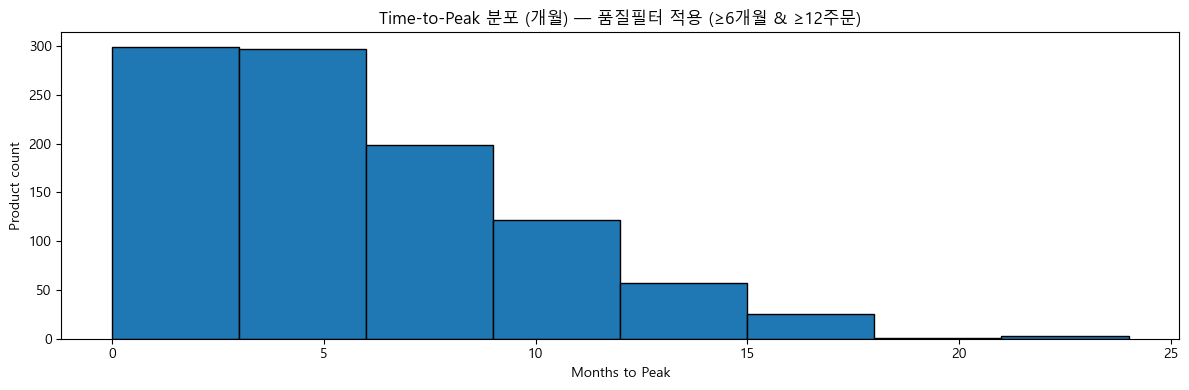

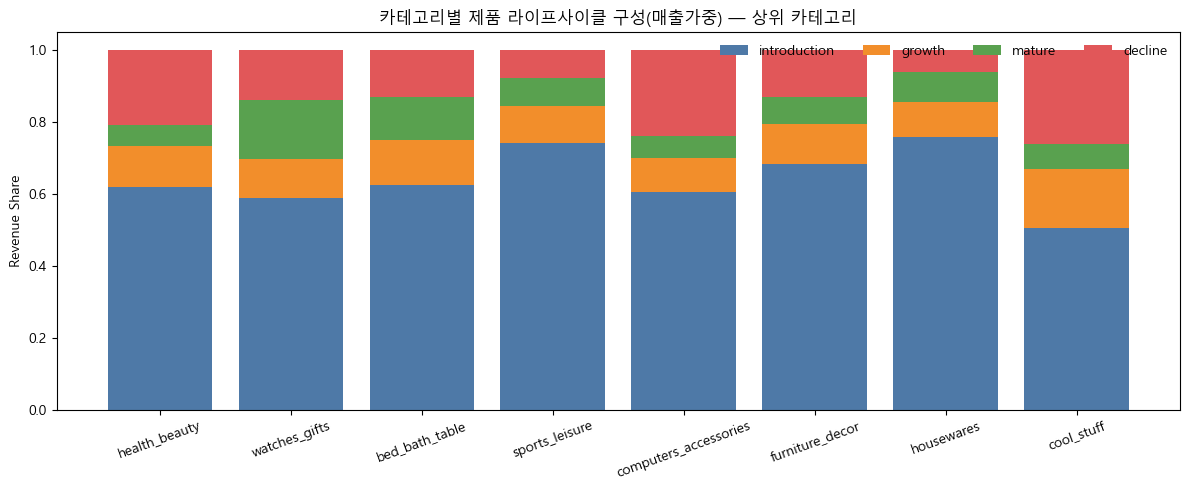

                              category_en  top20sku_share
11                      cds_dvds_musicals        1.000000
64  small_appliances_home_oven_and_coffee        0.888270
4                                   audio        0.842588
2                                     art        0.826798
68                              telephony        0.811783
34                        fixed_telephony        0.797712
18              construction_tools_lights        0.797096
70                                unknown        0.794872
42                           garden_tools        0.793972
43                          health_beauty        0.793897


C:\Users\배성우\AppData\Local\Temp\ipykernel_6168\2770745462.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conc = sku_conc.groupby("category_en").apply(top20_share).rename("top20sku_share").reset_index()


In [17]:
# ---------------- 튜닝 파라미터 ----------------
MIN_MONTHS   = 6     # SKU 가 최소 활동한 개월 수
MIN_ORDERS   = 12    # SKU 누적 주문수 최소치
TOP_CAT_N    = 8     # 상위 카테고리 시각화 개수
BINS_STEP    = 3     # 히스토그램 bin 간격(개월)

# 1) SKU 수준 보조 지표: 주문수/매출 집계
sku_orders = (base.groupby(["product_id"])["order_id"]
                .nunique().rename("orders_total").reset_index())
sku_sales  = (base.groupby(["product_id"])["price"]
                .sum().rename("sales_total").reset_index())

sku_meta = (product_lifecycle[["product_id","category_en","months_active","time_to_peak","stage"]]
            .merge(sku_orders, on="product_id", how="left")
            .merge(sku_sales,  on="product_id", how="left"))

# 2) 품질 필터: 활동 개월 & 주문 최소치 통과
mask_stable = (sku_meta["months_active"] >= MIN_MONTHS) & (sku_meta["orders_total"] >= MIN_ORDERS)
sku_stable  = sku_meta.loc[mask_stable].copy()

print(f"전체 SKU: {len(sku_meta):,}  |  필터 통과 SKU: {len(sku_stable):,} "
      f"({len(sku_stable)/max(len(sku_meta),1):.1%})")

# 3) (개선) 히스토그램: 필터 통과 SKU만
tp = sku_stable["time_to_peak"].replace([np.inf,-np.inf], np.nan).dropna()
if len(tp) > 0:
    import numpy as np, matplotlib.pyplot as plt
    bins = np.arange(0, np.nanmax(tp)+BINS_STEP, BINS_STEP)
    plt.figure(figsize=(12,4))
    plt.hist(tp, bins=bins, edgecolor="black")
    plt.title(f"Time-to-Peak 분포 (개월) — 품질필터 적용 (≥{MIN_MONTHS}개월 & ≥{MIN_ORDERS}주문)")
    plt.xlabel("Months to Peak"); plt.ylabel("Product count")
    plt.tight_layout(); plt.show()
else:
    print("⚠️ 품질필터 통과 SKU에 유효한 time_to_peak가 없습니다.")

# 4) (개선) 카테고리별 단계 비중: '개수'가 아니라 '매출가중'
stage_rev = (base[["product_id","price"]]
                .merge(sku_meta[["product_id","category_en","stage"]], on="product_id", how="left")
                .groupby(["category_en","stage"])["price"].sum()
                .reset_index().rename(columns={"price":"sales"}))

# 카테고리 총매출 대비 단계별 매출비중
cat_total = stage_rev.groupby("category_en")["sales"].sum().rename("cat_sales")
stage_rev = stage_rev.merge(cat_total, on="category_en", how="left")
stage_rev["share"] = stage_rev["sales"] / stage_rev["cat_sales"]

# 상위 카테고리 선택(총매출 기준)
top_cats = (base.groupby("category_en")["price"]
              .sum().sort_values(ascending=False).head(TOP_CAT_N).index.tolist())

# 피벗(매출가중 스택바용)
stages_order = ["introduction","growth","mature","decline"]
pivot_rev = (stage_rev.pivot(index="category_en", columns="stage", values="share")
                      .reindex(index=top_cats, columns=[s for s in stages_order if s in stage_rev["stage"].unique()])
                      .fillna(0.0))

# 시각화: 매출가중 스택바
plt.figure(figsize=(12,5))
x = np.arange(len(pivot_rev))
bottom = np.zeros(len(pivot_rev))
colors = ["#4E79A7","#F28E2B","#59A14F","#E15759"]  # intro/growth/mature/decline
for i, s in enumerate(pivot_rev.columns):
    vals = pivot_rev[s].values
    plt.bar(x, vals, bottom=bottom, label=s, color=colors[i % len(colors)])
    bottom += vals
plt.title("카테고리별 제품 라이프사이클 구성(매출가중) — 상위 카테고리")
plt.xticks(x, pivot_rev.index, rotation=20)
plt.ylabel("Revenue Share")
plt.legend(frameon=False, ncol=len(pivot_rev.columns))
plt.tight_layout(); plt.show()

# 5) 보너스: SKU 집중도(파레토)로 '롱테일 영향' 확인
sku_conc = (base.groupby(["category_en","product_id"])["price"].sum()
               .reset_index().sort_values(["category_en","price"], ascending=[True,False]))
def top20_share(df):
    tot = df["price"].sum()
    top = df["price"].head(int(max(1, 0.2*len(df)))).sum()  # 상위 20% SKU 매출
    return top / tot if tot>0 else np.nan
conc = sku_conc.groupby("category_en").apply(top20_share).rename("top20sku_share").reset_index()
print(conc.sort_values("top20sku_share", ascending=False).head(10))


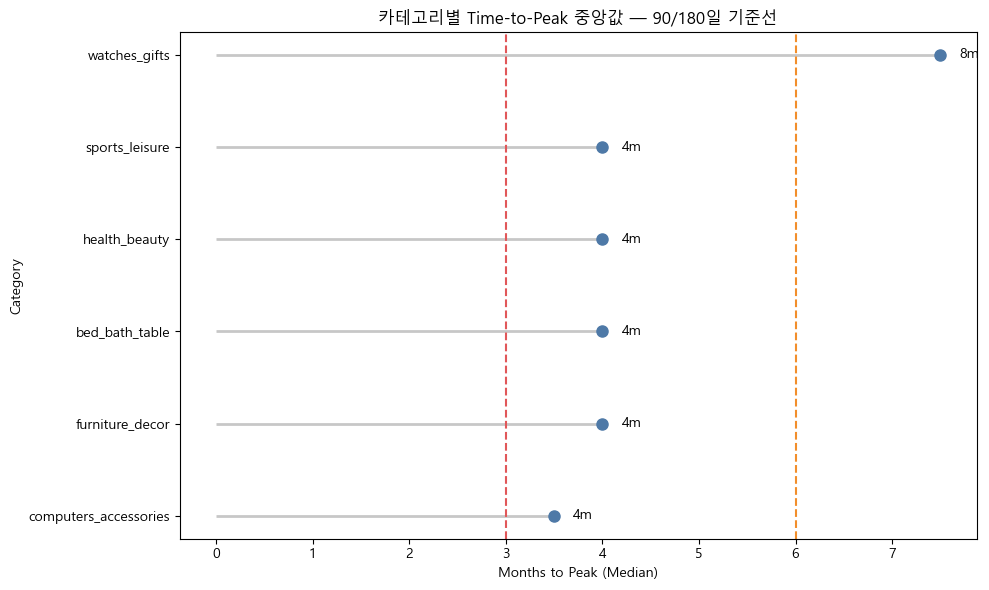

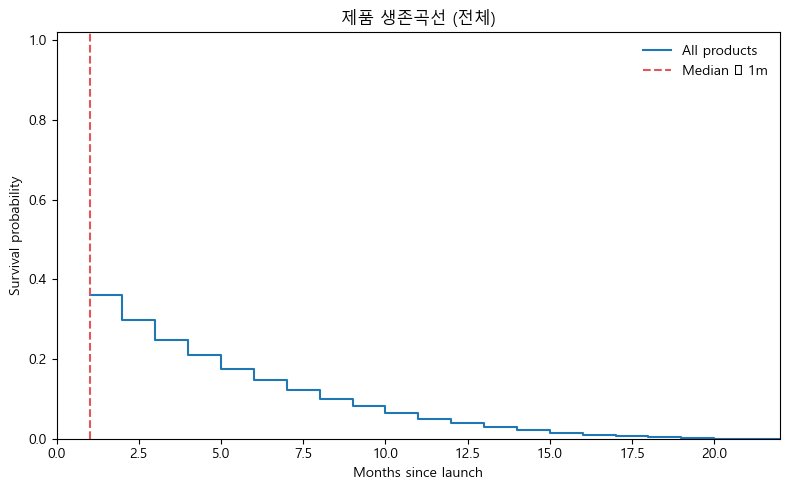

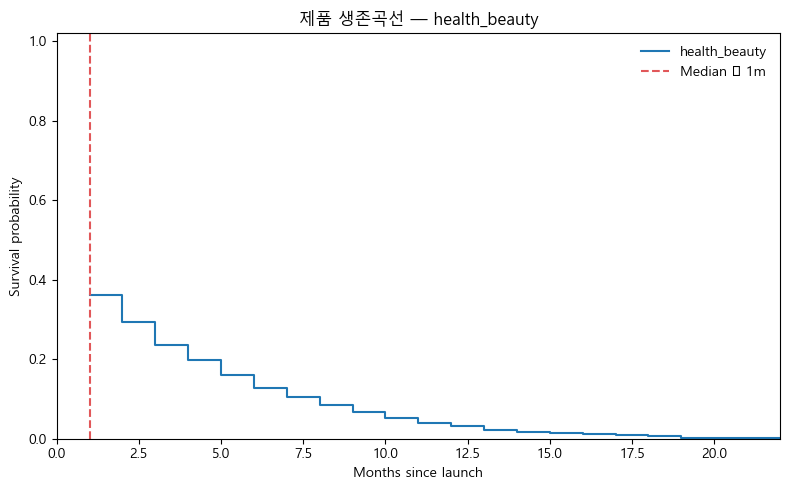

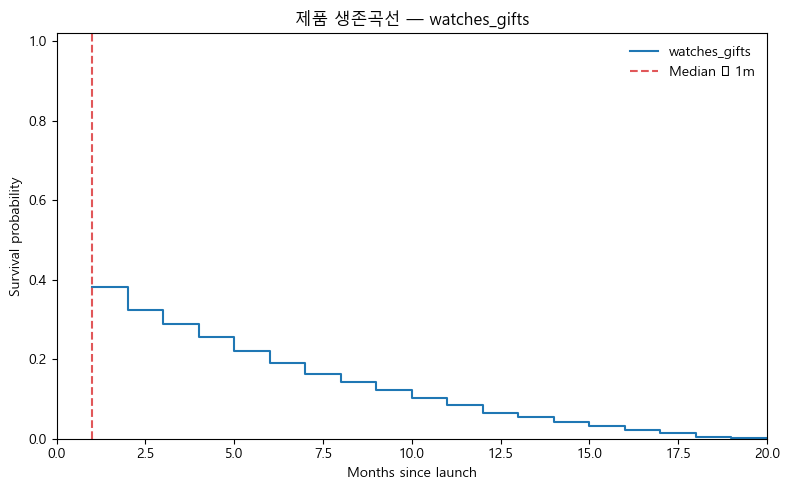

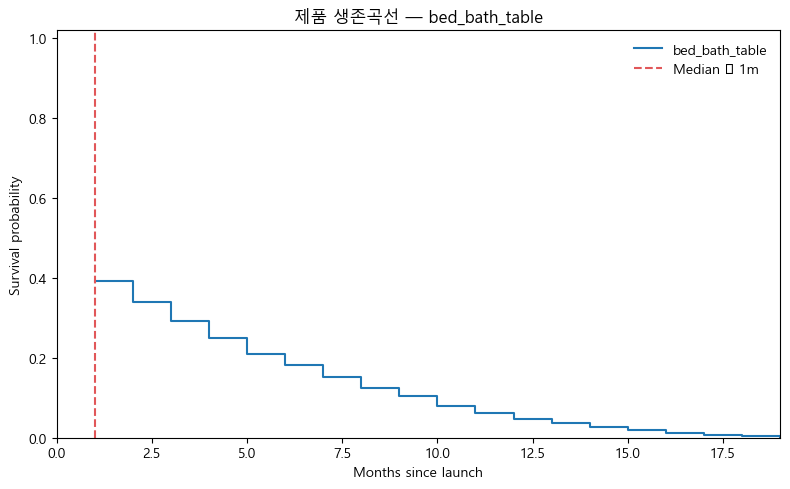

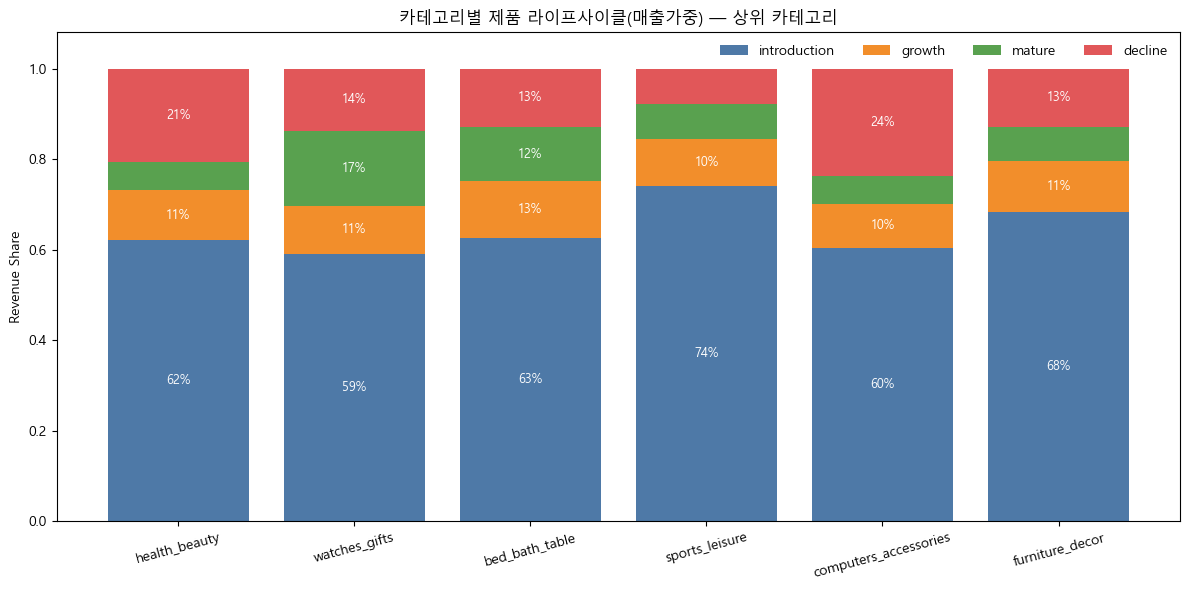

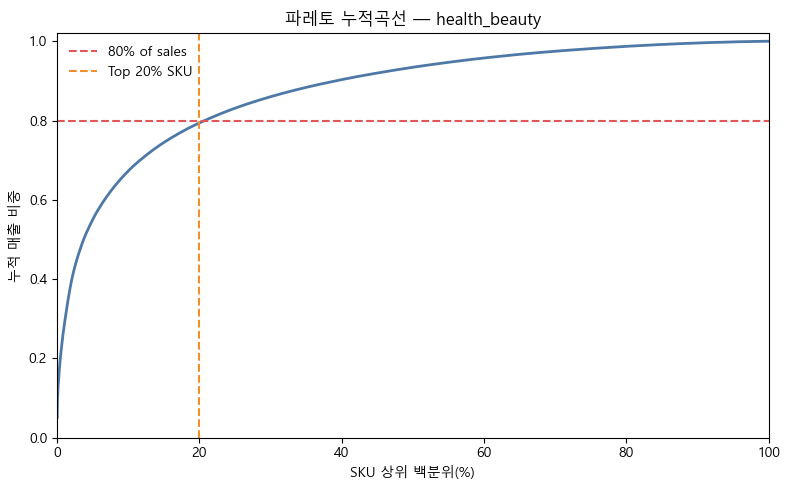

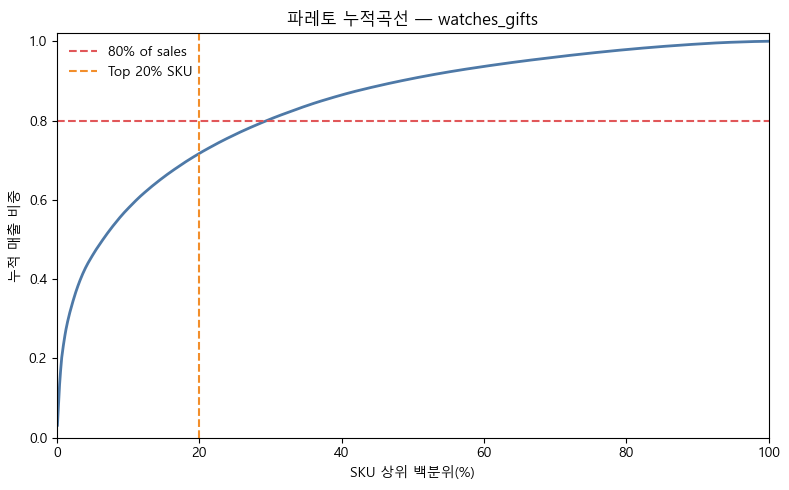

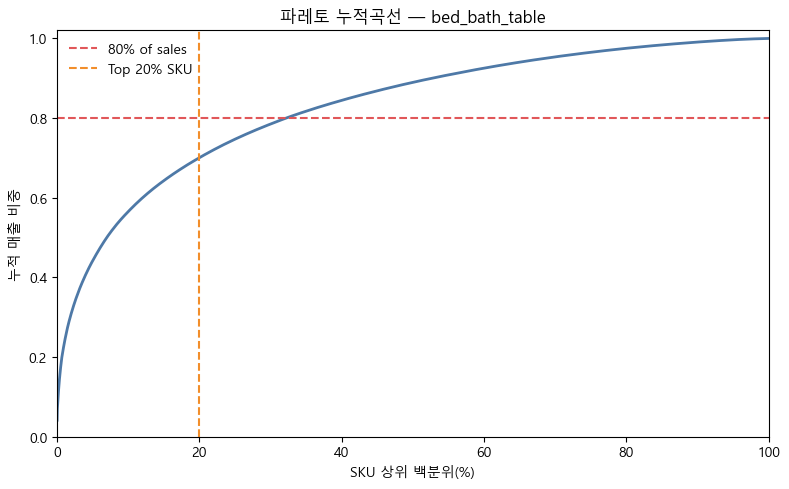

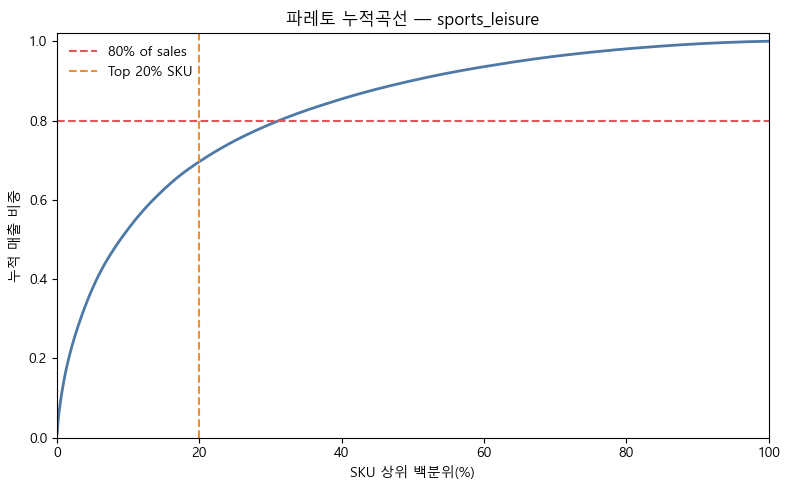

C:\Users\배성우\AppData\Local\Temp\ipykernel_6168\1029997577.py:242: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby("category_en").apply(_top20_share).rename("top20_share").reset_index())


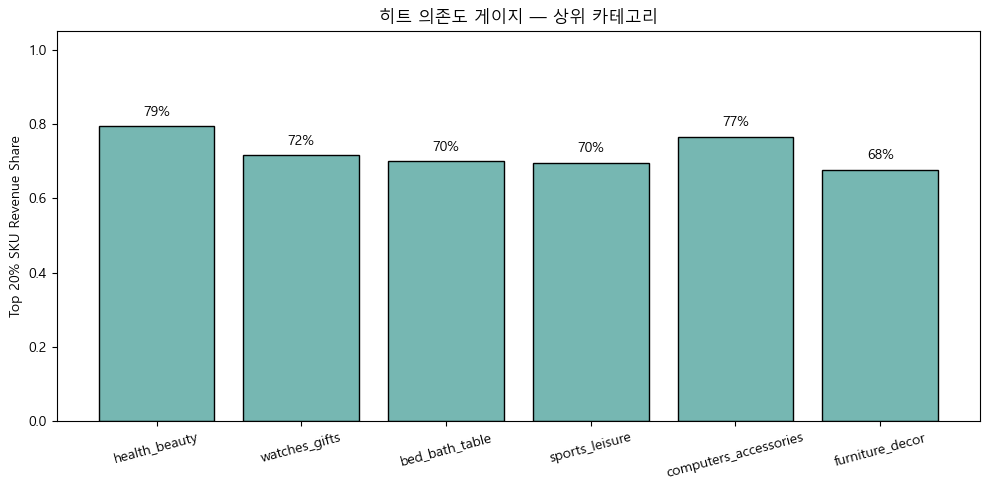

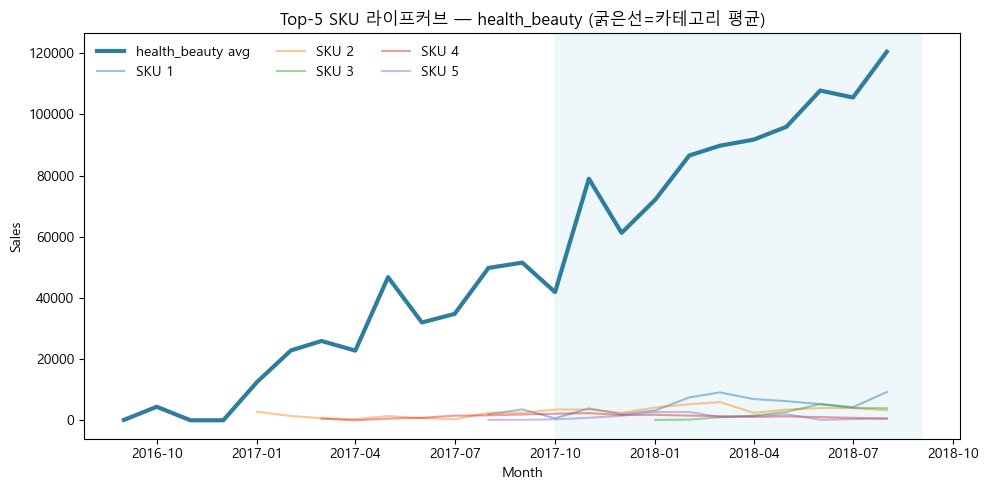

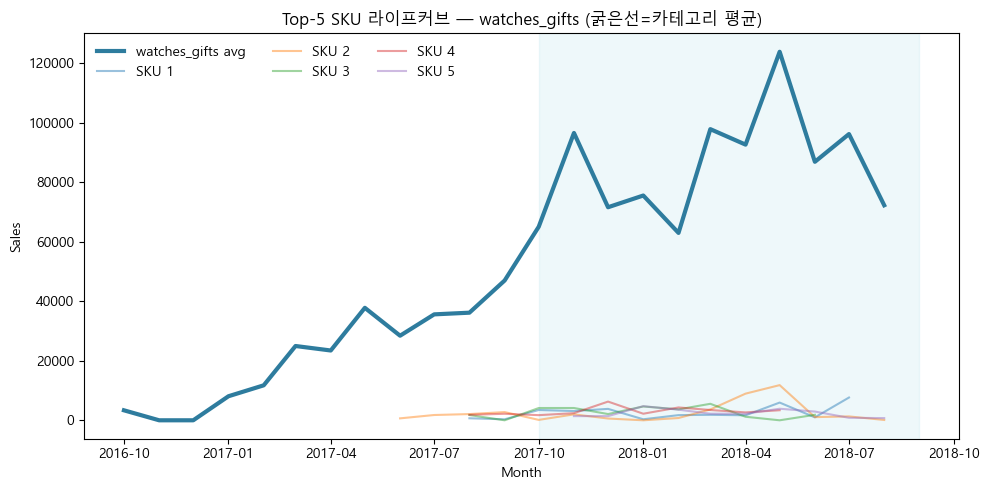

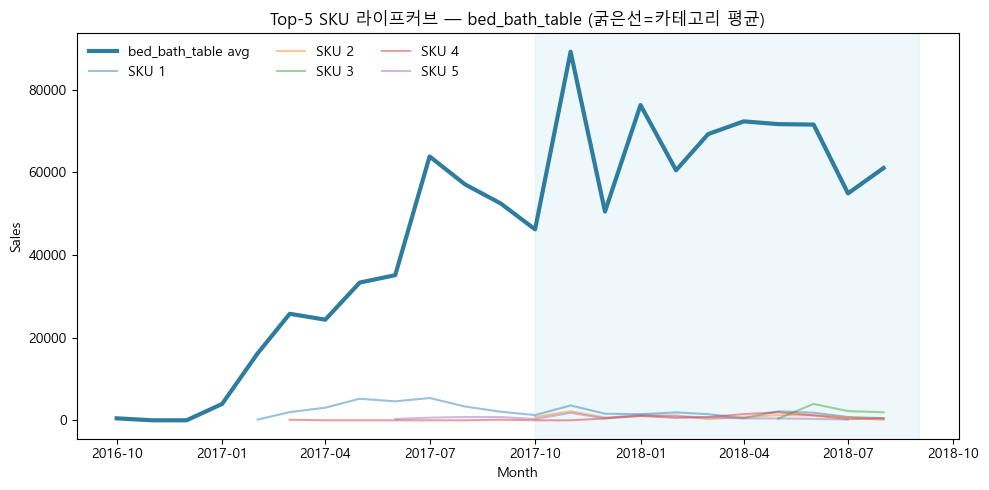

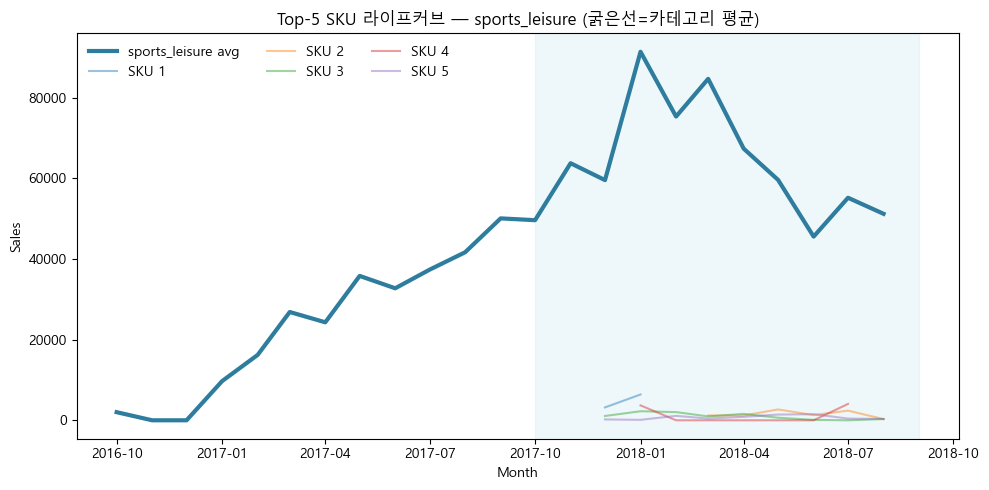

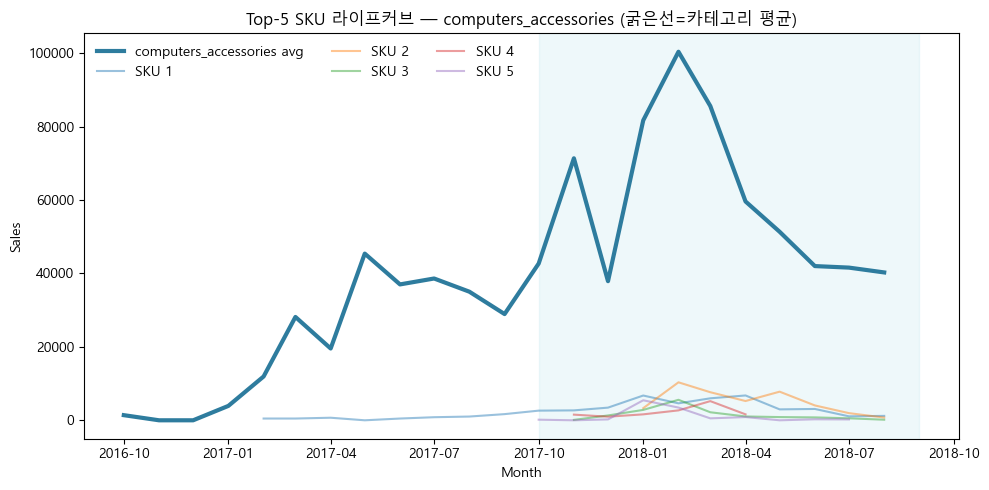

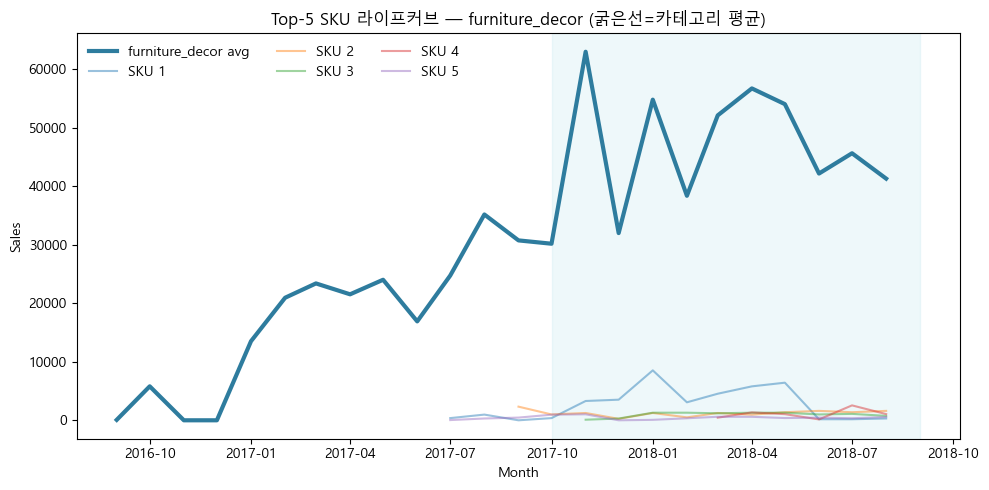

✅ 완료: 1) TTP 로리팝  2) KM(전체+카테고리3)  3) 매출가중 스택바  6) 파레토/게이지  8) Top-SKU 오버레이


In [20]:
# =========================================================
# 발표용 시각화 세트: (1) TTP 로리팝, (2) KM 생존, (3) 매출가중 라이프사이클,
# (6) SKU 파레토/게이지, (8) Top-SKU 라이프커브 오버레이
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- 파라미터(원하면 바꾸세요) ----------------
MIN_MONTHS   = 6         # 품질필터: SKU 활동 개월
MIN_ORDERS   = 12        # 품질필터: SKU 주문 수
TOP_CAT_N    = 6         # 주요 카테고리 개수(스택바/버블/오버레이 등)
CENSOR_BUF   = 1         # KM: 관측종료 직전 개월은 검열 처리
DECLINE_ALERT= 0.25      # Decline 매출비중 경고 기준(예: 25%)
OVERLAY_TOPK = 5         # 오버레이: 카테고리 내 상위 SKU 수(최근12M 매출)
PALETTE      = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
                "#EDC948","#B07AA1","#FF9DA7","#9C755F","#2E7C9E"]

# ---------------- 공통 준비 ----------------
def ensure_category_en(products_clean, category_tr_clean=None):
    if "category_en" in products_clean.columns:
        return products_clean
    prod = products_clean.copy()
    if category_tr_clean is not None and "product_category_name" in prod.columns:
        m = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
        prod["category_en"] = prod["product_category_name"].map(m).fillna("unknown")
    else:
        prod["category_en"] = prod.get("product_category_name", "unknown")
    return prod

def month_diff(end, start):
    m = (end.dt.year - start.dt.year)*12 + (end.dt.month - start.dt.month)
    m = m.astype("float")
    m[(end.isna()) | (start.isna())] = np.nan
    return m

# category_en 보장
products_clean = ensure_category_en(products_clean, category_tr_clean if "category_tr_clean" in globals() else None)

# base 생성(없으면)
if "base" not in globals():
    valid_status = ["delivered","invoiced","shipped","processing","created"]
    base = (orders_clean[["order_id","customer_id","order_purchase_timestamp","order_status"]]
            .merge(order_items_clean[["order_id","product_id","price"]], on="order_id", how="inner")
            .merge(products_clean[["product_id","category_en"]], on="product_id", how="left"))
    base = base[base["order_status"].isin(valid_status)].copy()
    base["order_date"]  = pd.to_datetime(base["order_purchase_timestamp"], errors="coerce").dt.normalize()
    base["order_month"] = base["order_date"].dt.to_period("M").dt.to_timestamp()
    base["category_en"] = base["category_en"].fillna("unknown")

# 제품×월 매출
prod_m = (base.groupby(["product_id","category_en","order_month"])["price"]
             .sum().reset_index().rename(columns={"price":"sales"})).sort_values(["product_id","order_month"])

# 제품 메타(출시/종료/나이/피크)
first_last = prod_m.groupby("product_id")["order_month"].agg(first_month="min", last_month="max").reset_index()
peak_idx   = prod_m.groupby("product_id")["sales"].idxmax()
peak_map   = prod_m.loc[peak_idx, ["product_id","order_month"]].rename(columns={"order_month":"peak_month"})

sku_orders = base.groupby("product_id")["order_id"].nunique().rename("orders_total").reset_index()
sku_sales  = base.groupby("product_id")["price"].sum().rename("sales_total").reset_index()

meta = (first_last
        .merge(peak_map, on="product_id", how="left")
        .merge(products_clean[["product_id","category_en"]], on="product_id", how="left")
        .merge(sku_orders, on="product_id", how="left")
        .merge(sku_sales,  on="product_id", how="left"))
meta["age_months"]   = month_diff(meta["last_month"], meta["first_month"]) + 1.0
meta["time_to_peak"] = month_diff(meta["peak_month"], meta["first_month"])

# 단계 판정(최근3 vs 직전3 이동평균)
prod_m = prod_m.sort_values(["product_id","order_month"])
prod_m["ma3"] = prod_m.groupby("product_id")["sales"].transform(lambda s: s.rolling(3, min_periods=1).mean())
def _stage_of_product(g, recent=3, prev=3):
    g = g.sort_values("order_month")
    if len(g) < (recent+prev): return "introduction"
    last = g["ma3"].tail(recent).mean()
    prv  = g["ma3"].tail(recent+prev).head(prev).mean()
    if prv <= 0: return "introduction"
    delta = (last - prv)/prv
    if len(g) <= 3: return "introduction"
    if delta >= 0.15: return "growth"
    if delta <= -0.15 and len(g) >= 6: return "decline"
    if abs(delta) < 0.10: return "mature"
    return "mature"
stage_map = {pid: _stage_of_product(g) for pid, g in prod_m.groupby("product_id", sort=False)}
meta["stage"] = meta["product_id"].map(stage_map)

# 품질필터 SKU
mask_stable = (meta["age_months"] >= MIN_MONTHS) & (meta["orders_total"] >= MIN_ORDERS)
meta_stable  = meta.loc[mask_stable].copy()

# 상위 카테고리 선정(최근12M 매출)
last_month = base["order_month"].max()
cut_12     = last_month - pd.DateOffset(months=11)
cat_sales_recent = (base[base["order_month"]>=cut_12]
                    .groupby("category_en")["price"].sum().sort_values(ascending=False))
top_cats = cat_sales_recent.head(TOP_CAT_N).index.tolist()

# =========================================================
# (1) Time-to-Peak 로리팝 (90/180일 기준선)
# =========================================================
ttp_by_cat = (meta_stable.groupby("category_en")["time_to_peak"]
              .median().dropna().sort_values())
sel = ttp_by_cat.loc[ttp_by_cat.index.isin(top_cats)].sort_values()  # 상위 카테고리만
if len(sel)>0:
    plt.figure(figsize=(10,6))
    y = np.arange(len(sel))
    plt.hlines(y, xmin=0, xmax=sel.values, color="#C7C7C7", linewidth=2)
    plt.plot(sel.values, y, "o", color="#4E79A7", markersize=8)
    for i, (cat, v) in enumerate(sel.items()):
        plt.text(v+0.2, i, f"{v:.0f}m", va="center", fontsize=10)
    plt.axvline(3,  color="#E15759", linestyle="--", linewidth=1.5)  # 90일
    plt.axvline(6,  color="#F28E2B", linestyle="--", linewidth=1.5)  # 180일
    plt.yticks(y, sel.index)
    plt.xlabel("Months to Peak (Median)"); plt.ylabel("Category")
    plt.title("카테고리별 Time-to-Peak 중앙값 — 90/180일 기준선")
    plt.tight_layout(); plt.show()
else:
    print("⚠️ 품질필터 후 time_to_peak 중앙값이 존재하는 카테고리가 없습니다.")

# =========================================================
# (2) KM 생존곡선 — 전체 + 카테고리별 3개
# =========================================================
def km_curve(durations: pd.Series, events: pd.Series) -> pd.DataFrame:
    t_values = np.arange(1, int(durations.max()), dtype=int)
    at_risk  = np.array([(durations >= t).sum() for t in t_values], dtype=float)
    events_t = np.array([(((durations==t) & (events==1)).sum()) for t in t_values], dtype=float)
    surv, s = [], 1.0
    for n_i, d_i in zip(at_risk, events_t):
        if n_i > 0:
            s *= (1.0 - d_i / n_i)
        surv.append(s)
    return pd.DataFrame({"t": t_values, "survival": surv})

# event 관측 여부(검열 처리)
last_obs_month = meta["last_month"].max()
censor_cutoff  = last_obs_month - pd.DateOffset(months=CENSOR_BUF)
meta["event_observed"] = (meta["last_month"] <= censor_cutoff).astype(int)
meta["duration_i"]     = meta["age_months"].clip(lower=1).astype(int)

# 전체
km_all = km_curve(meta["duration_i"], meta["event_observed"])
median_all = km_all.loc[km_all["survival"]<=0.5, "t"].min() if (km_all["survival"]<=0.5).any() else np.nan
plt.figure(figsize=(8,5))
plt.step(km_all["t"], km_all["survival"], where="post", label="All products")
if pd.notna(median_all):
    plt.axvline(median_all, linestyle="--", color="#E15759", label=f"Median ≈ {int(median_all)}m")
plt.ylim(0,1.02); plt.xlim(0, min(36, int(km_all["t"].max())))
plt.xlabel("Months since launch"); plt.ylabel("Survival probability")
plt.title("제품 생존곡선 (전체)")
plt.legend(frameon=False)
plt.tight_layout(); plt.show()

# 카테고리별 3개(매출 상위)
for cat in top_cats[:3]:
    g = meta.loc[meta["category_en"]==cat]
    if len(g) < 20: 
        continue
    km = km_curve(g["duration_i"], g["event_observed"])
    med = km.loc[km["survival"]<=0.5, "t"].min() if (km["survival"]<=0.5).any() else np.nan
    plt.figure(figsize=(8,5))
    plt.step(km["t"], km["survival"], where="post", label=cat)
    if pd.notna(med):
        plt.axvline(med, linestyle="--", color="#E15759", label=f"Median ≈ {int(med)}m")
    plt.ylim(0,1.02); plt.xlim(0, min(36, int(km["t"].max())))
    plt.xlabel("Months since launch"); plt.ylabel("Survival probability")
    plt.title(f"제품 생존곡선 — {cat}")
    plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

# =========================================================
# (3) 매출가중 라이프사이클 스택바(상위 6) + Decline 경고
# =========================================================
stage_rev = (base[["product_id","price"]]
             .merge(meta[["product_id","category_en","stage"]], on="product_id", how="left")
             .groupby(["category_en","stage"])["price"].sum()
             .reset_index().rename(columns={"price":"sales"}))
cat_tot = stage_rev.groupby("category_en")["sales"].sum().rename("cat_sales")
stage_rev = stage_rev.merge(cat_tot, on="category_en", how="left")
stage_rev["share"] = stage_rev["sales"]/stage_rev["cat_sales"]

stages_order = [s for s in ["introduction","growth","mature","decline"] if s in stage_rev["stage"].unique()]
pivot = (stage_rev.pivot(index="category_en", columns="stage", values="share")
         .reindex(index=top_cats, columns=stages_order).fillna(0.0))

plt.figure(figsize=(12,6))
x = np.arange(len(pivot))
bottom = np.zeros(len(pivot))
stack_colors = ["#4E79A7","#F28E2B","#59A14F","#E15759"]
for i, s in enumerate(pivot.columns):
    vals = pivot[s].values
    plt.bar(x, vals, bottom=bottom, color=stack_colors[i%len(stack_colors)], label=s)
    # 각 세그먼트 라벨(작으면 생략)
    for xi, v, b in zip(x, vals, bottom):
        if v >= 0.08:
            plt.text(xi, b+v/2, f"{v*100:.0f}%", ha="center", va="center", fontsize=9, color="white")
    bottom += vals

# Decline 경고 아이콘
if "decline" in pivot.columns:
    dvals = pivot["decline"].values
    for xi, dv in zip(x, dvals):
        if dv >= DECLINE_ALERT:
            plt.text(xi, 1.02, "🚨", ha="center", va="bottom", fontsize=14)

plt.xticks(x, pivot.index, rotation=15)
plt.ylim(0, 1.08)
plt.ylabel("Revenue Share"); plt.title("카테고리별 제품 라이프사이클(매출가중) — 상위 카테고리")
plt.legend(frameon=False, ncol=len(pivot.columns))
plt.tight_layout(); plt.show()

# =========================================================
# (6) SKU 파레토 누적곡선 + Top20% 게이지
# =========================================================
# 누적곡선(상위 4카테고리)
for cat in top_cats[:4]:
    g = (base[base["category_en"]==cat]
         .groupby("product_id")["price"].sum().sort_values(ascending=False)).reset_index(drop=True)
    if len(g)==0: 
        continue
    cum = g.cumsum()/g.sum()
    x_pct = (np.arange(1, len(g)+1)/len(g))*100
    plt.figure(figsize=(8,5))
    plt.plot(x_pct, cum.values, linewidth=2, color="#4E79A7")
    plt.axhline(0.8, color="#E15759", linestyle="--", label="80% of sales")
    plt.axvline(20, color="#F28E2B", linestyle="--", label="Top 20% SKU")
    plt.title(f"파레토 누적곡선 — {cat}")
    plt.xlabel("SKU 상위 백분위(%)"); plt.ylabel("누적 매출 비중")
    plt.xlim(0,100); plt.ylim(0,1.02)
    plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

# 게이지: Top20% SKU 매출비중(상위 카테고리)
def _top20_share(df):
    tot = df["price"].sum()
    top_n = max(1, int(0.2*len(df)))
    return df["price"].sort_values(ascending=False).head(top_n).sum()/tot if tot>0 else np.nan

conc = (base.groupby(["category_en","product_id"])["price"].sum().reset_index()
          .groupby("category_en").apply(_top20_share).rename("top20_share").reset_index())
conc = conc.set_index("category_en").loc[top_cats].reset_index()

plt.figure(figsize=(10,5))
plt.bar(conc["category_en"], conc["top20_share"], color="#76B7B2", edgecolor="black")
for i, v in enumerate(conc["top20_share"]):
    plt.text(i, v+0.02, f"{v*100:.0f}%", ha="center", va="bottom")
plt.ylim(0,1.05); plt.xticks(rotation=15)
plt.ylabel("Top 20% SKU Revenue Share")
plt.title("히트 의존도 게이지 — 상위 카테고리")
plt.tight_layout(); plt.show()

# =========================================================
# (8) Top-SKU 라이프커브 오버레이(카테고리별)
#  - 각 카테고리에서 최근12M 매출 상위 OVERLAY_TOPK개 SKU의 월매출을 얇게 겹쳐 그림
# =========================================================
for cat in top_cats:
    # 최근12M 상위 SKU
    recent = base[(base["category_en"]==cat) & (base["order_month"]>=cut_12)]
    sku_top = (recent.groupby("product_id")["price"].sum()
               .sort_values(ascending=False).head(OVERLAY_TOPK).index.tolist())
    if len(sku_top)==0:
        continue
    plt.figure(figsize=(10,5))
    # 카테고리 평균선
    cat_series = (base[base["category_en"]==cat]
                  .groupby("order_month")["price"].sum().asfreq("MS", fill_value=0.0))
    plt.plot(cat_series.index, cat_series.values, linewidth=3, label=f"{cat} avg", color="#2E7C9E")
    # SKU 곡선들
    for i, pid in enumerate(sku_top):
        s = (base[base["product_id"]==pid]
             .groupby("order_month")["price"].sum().asfreq("MS", fill_value=0.0))
        plt.plot(s.index, s.values, linewidth=1.5, alpha=0.45, label=f"SKU {i+1}")
    # 영역: 최근 12개월 하이라이트
    plt.axvspan(cut_12, last_month, color="#C7E9F1", alpha=0.3)
    plt.title(f"Top-{OVERLAY_TOPK} SKU 라이프커브 — {cat} (굵은선=카테고리 평균)")
    plt.xlabel("Month"); plt.ylabel("Sales")
    plt.legend(frameon=False, ncol=3)
    plt.tight_layout(); plt.show()

print("✅ 완료: 1) TTP 로리팝  2) KM(전체+카테고리3)  3) 매출가중 스택바  6) 파레토/게이지  8) Top-SKU 오버레이")
